In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import netCDF4 as nc

import sys

sys.path.append('../../')

import utils as s3u
from nc_explorer import NcExplorer
from tsgen import TsGenerator

tsg = TsGenerator()

sen3r-NcExplorer: from mpl_toolkits.basemap import Basemap FAILED!
You can still proceed without plotting any maps.



In [2]:
# Estimate AOT from 865nm

In [3]:
# aot550 = np.array(aot865)*(865/550)**np.array(ang)

## Testing over all available bands

In [4]:
path = Path('/d_drive_data/S3/SY_2_SYN/S3A_SY_2_SYN____20191104T135002_20191104T135302_20191106T033418_0180_051_124_3060_LN2_O_NT_002.SEN3')
exp_syn = NcExplorer(input_nc_folder=path, product='syn')

Declaring class instance from: SEN3R:nc_explorer
Reading valid NetCDF files inside image folder...
Product set to SYN.
Loading image bands into memory, this may take a while...


## READ BUFFER POLYGON

In [5]:
%time syn_xy_vertices, syn_ll_vertices = exp_syn.get_xy_polygon_from_json(poly_path='/home/dvdgmf/qgis_out/manacapuru_buffer.geojson')
# %time xy_vertices, ll_vertices = exp.get_xy_polygon_from_json(poly_path='/d_drive_data/downloads/manacapuru_complex.geojson')

CPU times: user 83.8 ms, sys: 223 ms, total: 307 ms
Wall time: 4.58 s


In [6]:
syn_a550 = nc.Dataset(exp_syn.nc_folder/'Syn_Angstrom_exp550.nc')
exp_syn.a550 = syn_a550['A550'][:]

syn_t550 = nc.Dataset(exp_syn.nc_folder/'Syn_AOT550.nc')
exp_syn.t550 = syn_t550['T550'][:]

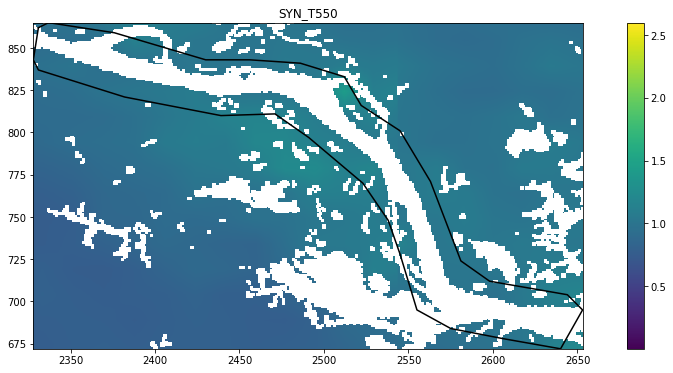

In [7]:
band = exp_syn.t550
bname = 'SYN_T550'

# band = exp_syn.a550
# bname = 'SYN_A550'

vertices = syn_xy_vertices

xmin, xmax, ymin, ymax = s3u.bbox(syn_xy_vertices)

plt.rcParams['figure.figsize'] = [16, 6]
plt.title(bname)
plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.imshow(band)
for vert in vertices:
    plt.plot(vert[:,1],vert[:,0],c='k')
plt.colorbar()
plt.show()

In [8]:
# Generate extraction mask
from skimage.draw import polygon

img = np.zeros(exp_syn.g_lon.shape)
cc = np.ndarray(shape=(0,), dtype='int64')
rr = np.ndarray(shape=(0,), dtype='int64')

for vert in syn_xy_vertices:
    t_rr, t_cc = polygon(vert[:,0], vert[:,1], exp_syn.g_lon.shape)
    img[t_rr, t_cc] = 1
    cc = np.append(cc,t_cc)
    rr = np.append(rr,t_rr)

In [9]:
# Apply the mask and get the band information in the cc,rr coord pairs
band_values = band[rr, cc]

# Create a DF from the extracted reflectance
custom_subset = {bname:band_values.data,'x':rr,'y':cc}
df = pd.DataFrame(custom_subset)

df['lat'] = [exp_syn.g_lat[x,y] for x,y in zip(df['x'],df['y'])]
df['lon'] = [exp_syn.g_lon[x,y] for x,y in zip(df['x'],df['y'])]

df.head()

,SYN_T550,x,y,lat,lon
0,1.1659,672,2640,-3.286901,-60.490971
1,1.1422,673,2635,-3.287086,-60.502169
2,1.1482,673,2636,-3.287692,-60.499501
3,1.1541,673,2637,-3.288297,-60.496842
4,1.1541,673,2638,-3.288297,-60.496842


In [10]:
# drop outlier values (SYNERGY T550)
if bname == 'SYN_T550':
    indexNames = df[df[bname] < -100].index
    df.drop(indexNames, inplace=True)

In [12]:
# df.to_csv('S3A_SY_2_SYN____20191104T135002_t550.csv',index=False)

## SYN product has no data over water. Loading WFR product to also include it in the comparisson.

In [13]:
path = Path('/d_drive_data/S3/L2_WFR/S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3')
%time exp_wfr = NcExplorer(input_nc_folder=path, product='wfr')

Declaring class instance from: SEN3R:nc_explorer
Reading valid NetCDF files inside image folder...
Product set to WFR.
Loading image bands into memory, this may take a while...
CPU times: user 2.93 s, sys: 2.61 s, total: 5.55 s
Wall time: 2.75 s


In [14]:
%time wfr_xy_vertices, wfr_ll_vertices = exp_wfr.get_xy_polygon_from_json(poly_path='/home/dvdgmf/qgis_out/manacapuru_buffer.geojson')

CPU times: user 132 ms, sys: 455 ms, total: 587 ms
Wall time: 4.52 s


In [15]:
# Generate extraction mask
from skimage.draw import polygon

img = np.zeros(exp_wfr.g_lon.shape)
cc = np.ndarray(shape=(0,), dtype='int64')
rr = np.ndarray(shape=(0,), dtype='int64')

for vert in wfr_xy_vertices:
    t_rr, t_cc = polygon(vert[:,0], vert[:,1], exp_wfr.g_lon.shape)
    img[t_rr, t_cc] = 1
    cc = np.append(cc,t_cc)
    rr = np.append(rr,t_rr)

In [16]:
# Create a DF from the extracted values
custom_subset = {'x':rr,'y':cc}

df = pd.DataFrame(custom_subset)

df['lon'] = [exp_wfr.g_lon[x,y] for x,y in zip(df['x'],df['y'])]
df['lat'] = [exp_wfr.g_lat[x,y] for x,y in zip(df['x'],df['y'])]

df.head()

,x,y,lon,lat
0,672,2640,-60.490971,-3.286901
1,673,2635,-60.502169,-3.287086
2,673,2636,-60.499501,-3.287692
3,673,2637,-60.496842,-3.288297
4,673,2638,-60.496842,-3.288297


In [17]:
for k in exp_wfr.wfr_bands:
    ds = nc.Dataset(path/k)
    for layer in exp_wfr.wfr_bands[k]:
        print(f'extracting: {layer}')
        band = ds[layer][:]
        df[layer] = [band[x,y] for x,y in zip(df['x'],df['y'])]

extracting: A865
extracting: T865
extracting: Oa06_reflectance
extracting: Oa17_reflectance
extracting: WQSF


In [68]:
df.head()

,x,y,lon,lat,A865,T865,Oa06_reflectance,Oa17_reflectance,WQSF
0,672,2640,-60.490971,-3.286901,--,--,--,--,16777220
1,673,2635,-60.502169,-3.287086,--,--,--,--,4
2,673,2636,-60.499501,-3.287692,--,--,--,--,4
3,673,2637,-60.496842,-3.288297,--,--,--,--,16777220
4,673,2638,-60.496842,-3.288297,--,--,--,--,16777220


In [71]:
df['T865'].mask

<bound method NDFrame.mask of 0        --
1        --
2        --
3        --
4        --
         ..
13025    --
13026    --
13027    --
13028    --
13029    --
Name: T865, Length: 13030, dtype: object>

In [ ]:
# Delete indexes for which Oa01_reflectance is saturated:
# indexNames = df[df['Oa01_reflectance:float'] == 1.0000184].index
# df.drop(indexNames, inplace=True)

In [19]:
# df.to_csv('S3A_WFR_20191104T135002_df.csv',index=False)

## Loading kriging results

In [81]:
dfk = pd.read_csv('/home/dvdgmf/qgis_out/s3a_wfr_krig.csv',na_values='--')

In [82]:
dfk.head()

,x,y,lon,lat,A865,T865,Oa06_refle,Oa17_refle,WQSF,krigclipt55
0,672,2640,-60.490971,-3.286901,NaN,NaN,NaN,NaN,16777220,1.164514
1,673,2635,-60.502169,-3.287086,NaN,NaN,NaN,NaN,4,1.142192
2,673,2636,-60.499501,-3.287692,NaN,NaN,NaN,NaN,4,1.146119
3,673,2637,-60.496842,-3.288297,NaN,NaN,NaN,NaN,16777220,1.153353
4,673,2638,-60.496842,-3.288297,NaN,NaN,NaN,NaN,16777220,1.153353


In [93]:
# Drop NAN values and fix the indexing
dfk_no_nan = dfk.dropna().copy()
dfk_no_nan.reset_index(drop=True, inplace=True)

In [100]:
'{:.20f}'.format(dfk_no_nan['Oa17_refle'].min())

'0.00001220405100000000'

## COMPARE WITH CAMS

In [103]:
# LINUX
ncs = "/d_drive_data/git-repos/cams_visu/cams_visu/test_dl/cams_2019.nc"

cams_nc = nc.Dataset(ncs,'r')

# get the longitude information
lons = cams_nc.variables['longitude'][:]
# get the latitude information
lats = cams_nc.variables['latitude'][:]
# extract the time dimension
time = cams_nc.variables['time']

# creating 2D grids for further plotting
lon_grid, lat_grid = np.meshgrid(lons, lats)

# just to be sure (:
nc_date = str(nc.num2date(time[1230], time.units, time.calendar))
nc_date

'2019-11-04 12:00:00'

In [104]:
# get the total Aerosol Optical Depth at 550nm 
aod550 = cams_nc.variables['aod550'][1230][:]

# get the total Aerosol Optical Depth at 865nm 
aod865 = cams_nc.variables['aod865'][1230][:]

In [105]:
exp = NcExplorer()

# Manacapuru Centroid
query_lon, query_lat = -60.8911, -3.5726

mxy, query_aod_550 = exp.get_point_data_in_single_band(aod550,
                                  lon=lon_grid,lat=lat_grid,target_lon=query_lon,target_lat=query_lat)


_, query_aod_865 = exp.get_point_data_in_single_band(aod865,
                                  lon=lon_grid,lat=lat_grid,target_lon=query_lon,target_lat=query_lat)

mxy, query_aod_550, query_aod_865

Declaring class instance from: SEN3R:nc_explorer
Input NetCDF file folder not set. Proceed at your own risk.
initialize set to False, ignoring image geometries. This can be later done manually by calling initialize_geometries() after properly setting the nc_folder.


((69, 89), 0.6058359062664995, 0.3127664394840741)

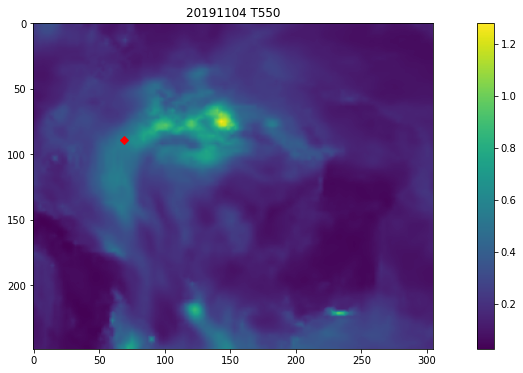

In [106]:
plt.title('20191104 T550')
plt.imshow(aod550)
plt.plot(mxy[0], mxy[1], 'rD')
plt.colorbar()

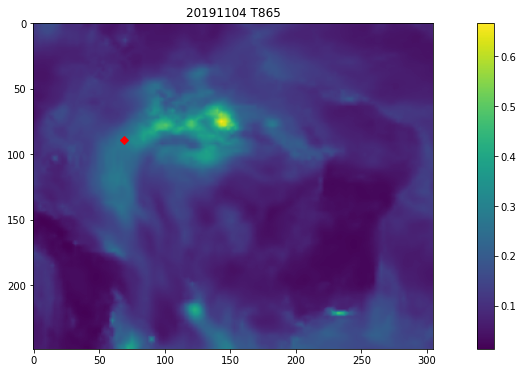

In [107]:
plt.title('20191104 T865')
# plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(aod865)
plt.plot(mxy[0], mxy[1], 'rD')
plt.colorbar()

In [115]:
dfk_no_nan['s3-cams-t865'] = dfk_no_nan['T865'] - query_aod_865
dfk_no_nan['s3-cams-t550'] = dfk_no_nan['krigclipt55'] - query_aod_550

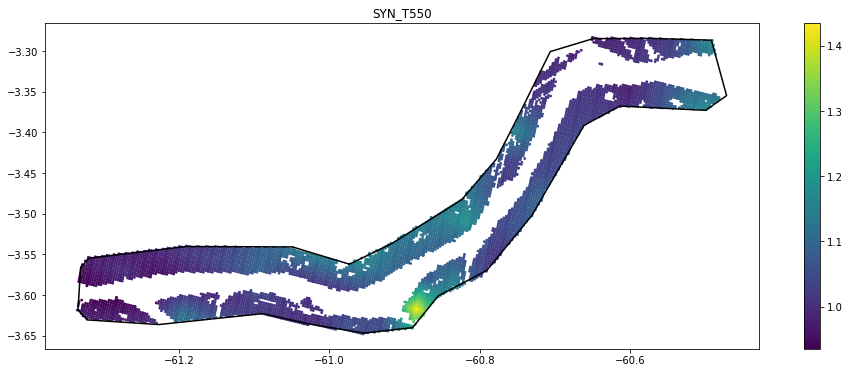

In [11]:
plt.rcParams['figure.figsize'] = [16, 6]
plt.title(bname)
plt.scatter(df['lon'],df['lat'],c=df['SYN_T550'],s=3)
plt.colorbar()

for vert in syn_ll_vertices:
    plt.plot(vert[:,0],vert[:,1],c='k')

plt.show()

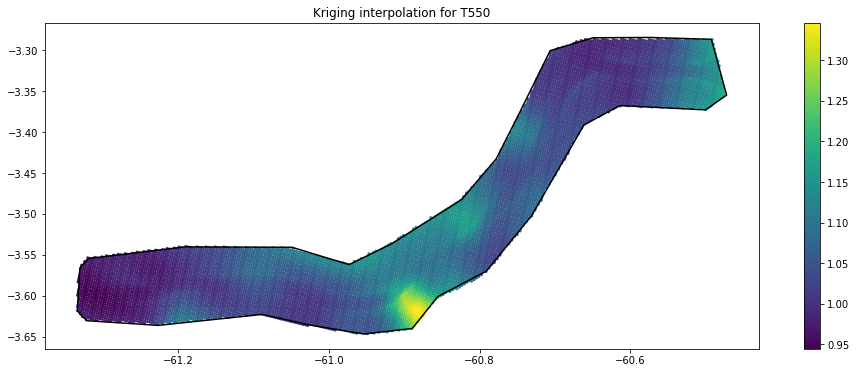

In [83]:
plt.rcParams['figure.figsize'] = [16, 6]
plt.title('Kriging interpolation for T550')
plt.scatter(dfk['lon'],dfk['lat'],c=dfk['krigclipt55'],s=3)
plt.colorbar()

for vert in syn_ll_vertices:
    plt.plot(vert[:,0],vert[:,1],c='k')

plt.show()

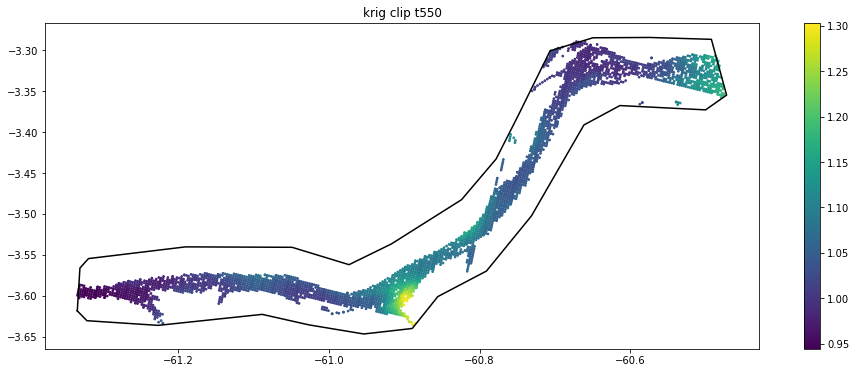

In [121]:
plt.rcParams['figure.figsize'] = [16, 6]
plt.title('S3_SYN krig clip t550')
plt.scatter(dfk_no_nan['lon'],dfk_no_nan['lat'],c=dfk_no_nan['krigclipt55'],s=3)
plt.colorbar()

for vert in syn_ll_vertices:
    plt.plot(vert[:,0],vert[:,1],c='k')

plt.show()

Text(0, 0.5, 'LAT')

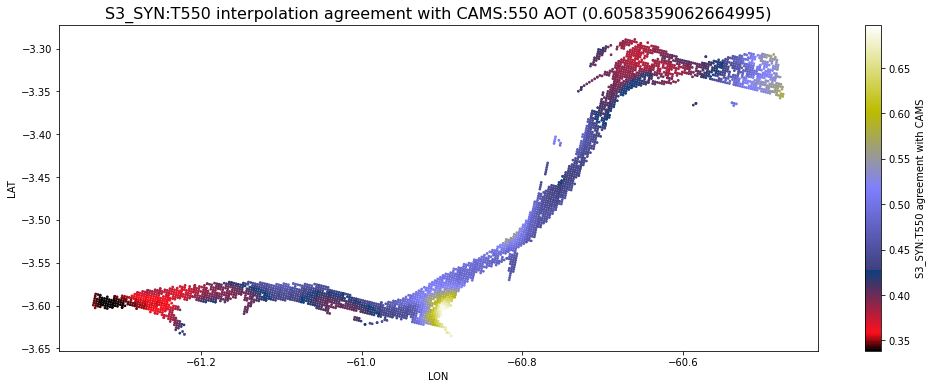

In [119]:
plt.rcParams['figure.figsize'] = [17, 6]
fig = plt.figure()
ax = plt.axes()
ax.set_title(f'S3_SYN:T550 interpolation agreement with CAMS:550 AOT ({query_aod_550})', fontsize=16)

# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['T865:float'], cmap='viridis', s=3)

sktmap = ax.scatter(dfk_no_nan['lon'], dfk_no_nan['lat'], c=dfk_no_nan['s3-cams-t550'], cmap='gist_stern', s=3)

# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='viridis', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='Greys_r', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='terrain', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='cubehelix', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='gist_rainbow', s=3)

cbar = fig.colorbar(sktmap, ax=ax)
# cbar.set_label('Aer. Optical Thickness (T865)')
cbar.set_label('S3_SYN:T550 agreement with CAMS')

# ax.set_xlim(-61.34, -60.46)
# ax.set_ylim(-3.65, -3.25)
ax.set_xlabel('LON')
ax.set_ylabel('LAT')

Text(0, 0.5, 'LAT')

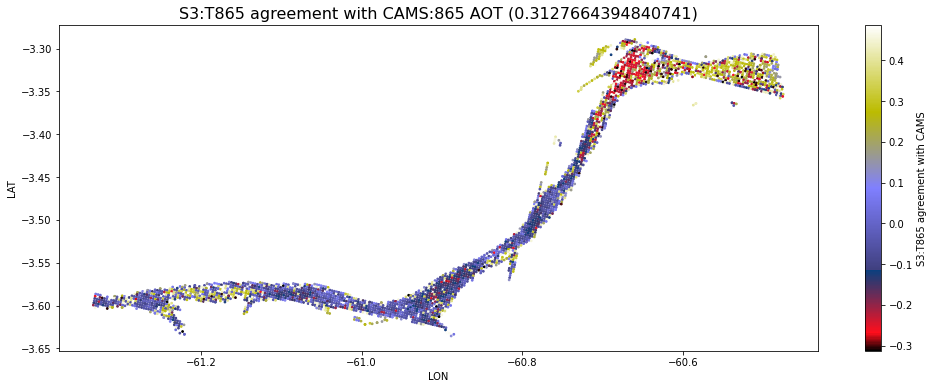

In [118]:
plt.rcParams['figure.figsize'] = [17, 6]
fig = plt.figure()
ax = plt.axes()
ax.set_title(f'S3:T865 agreement with CAMS:865 AOT ({query_aod_865})', fontsize=16)

# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['T865:float'], cmap='viridis', s=3)

sktmap = ax.scatter(dfk_no_nan['lon'], dfk_no_nan['lat'], c=dfk_no_nan['s3-cams_t865'], cmap='gist_stern', s=3)

# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='viridis', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='Greys_r', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='terrain', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='cubehelix', s=3)
# sktmap = ax.scatter(rdf['longitude:double'], rdf['latitude:double'], c=rdf['minus_cams'], cmap='gist_rainbow', s=3)

cbar = fig.colorbar(sktmap, ax=ax)
# cbar.set_label('Aer. Optical Thickness (T865)')
cbar.set_label('S3:T865 agreement with CAMS')

# ax.set_xlim(-61.34, -60.46)
# ax.set_ylim(-3.65, -3.25)
ax.set_xlabel('LON')
ax.set_ylabel('LAT')

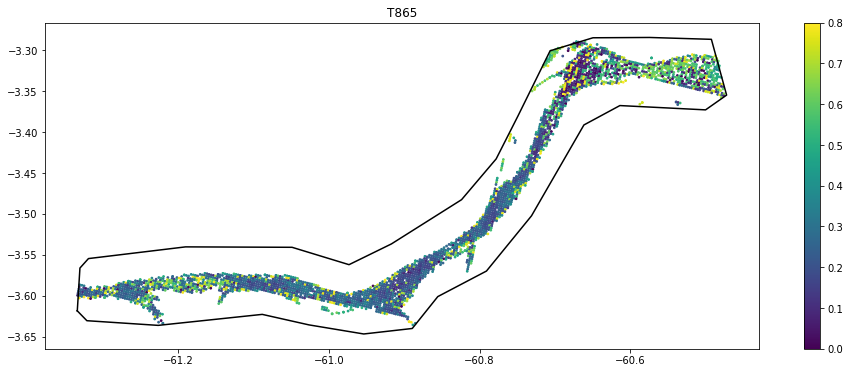

In [91]:
plt.rcParams['figure.figsize'] = [16, 6]
plt.title('T865')
plt.scatter(dfk_no_nan['lon'],dfk_no_nan['lat'],c=dfk_no_nan['T865'],s=3)
plt.colorbar()

for vert in syn_ll_vertices:
    plt.plot(vert[:,0],vert[:,1],c='k')

plt.show()

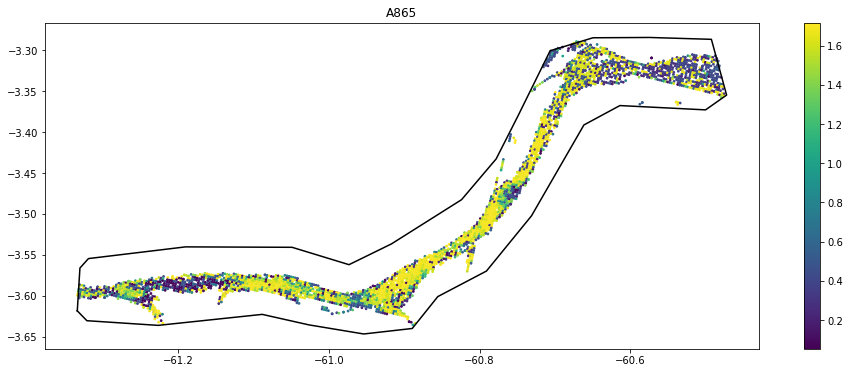

In [92]:
plt.rcParams['figure.figsize'] = [16, 6]
plt.title('A865')
plt.scatter(dfk_no_nan['lon'],dfk_no_nan['lat'],c=dfk_no_nan['A865'],s=3)
plt.colorbar()

for vert in syn_ll_vertices:
    plt.plot(vert[:,0],vert[:,1],c='k')

plt.show()